### Importing relevent libraries

In [1]:
import os
import PIL
import PIL.Image
from pathlib import Path
import tensorflow as tf
import pandas as pd
from livelossplot import PlotLossesKerasTF
import matplotlib.pyplot as plt
%matplotlib inline

print(tf.__version__)

2.8.3


Check if GPU is availabl.

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Loading data and creating datasets

In [3]:
os.chdir("..")

In [4]:
# Creating paths with data
DATA_DIR = Path('data')
DATA_DIR_TRAIN = DATA_DIR / 'train'
DATA_DIR_TEST = DATA_DIR / 'test_kaggle'

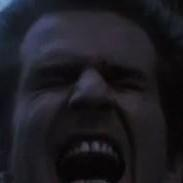

In [5]:
# Checking traim path
anger = list(DATA_DIR_TRAIN.glob('anger/*'))
PIL.Image.open(str(anger[0]))

In [7]:
# Folders with images are structured by classes, so we can use image_dataset_from_directory.
BATCH_SIZE = 64
IMG_HEIGHT = 224 # set image size as imagenet
IMG_WIDTH = 224

train_ds = tf.keras.utils.image_dataset_from_directory(DATA_DIR_TRAIN,
                                                       label_mode='categorical',
                                                       validation_split=0.2,
                                                       subset='training',
                                                       seed=0,
                                                       image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                       batch_size=BATCH_SIZE)

valid_ds = tf.keras.utils.image_dataset_from_directory(DATA_DIR_TRAIN,
                                                       label_mode='categorical',
                                                       validation_split=0.2,
                                                       subset='validation',
                                                       seed=0,
                                                       image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                       batch_size=BATCH_SIZE)

Found 50047 files belonging to 9 classes.
Using 40038 files for training.
Found 50047 files belonging to 9 classes.
Using 10009 files for validation.


In [8]:
# Checking classes
class_names = train_ds.class_names
print(class_names)

['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise', 'uncertain']


In [9]:
emotion_mapping = {k: v for v, k in enumerate(class_names)}
emotion_mapping

{'anger': 0,
 'contempt': 1,
 'disgust': 2,
 'fear': 3,
 'happy': 4,
 'neutral': 5,
 'sad': 6,
 'surprise': 7,
 'uncertain': 8}

### Creating custom model.

In [19]:
augmentation_layer = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal"),
                                          tf.keras.layers.RandomRotation(0.1),
                                          tf.keras.layers.RandomContrast(0.1)])
normalization_layer = tf.keras.layers.Rescaling(scale=1./127.5, offset=-1) # data preprocessing (scaling and centering)    

inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = augmentation_layer(inputs)
x = normalization_layer(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.AveragePooling2D()(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.AveragePooling2D()(x)
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)
model_norm_aug = tf.keras.Model(inputs, outputs)

In [20]:
model_norm_aug.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 conv2d_13 (Conv2D)          (None, 224, 224, 32)      9248      
                                                                 
 average_pooling2d_4 (Averag  (None, 112, 112, 32)     0         
 ePooling2D)                                                     
                                                           

In [21]:
LR = 1e-4
EPOCHS = 15

model_norm_aug.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
                          loss='categorical_crossentropy',
                          metrics=['categorical_accuracy'])

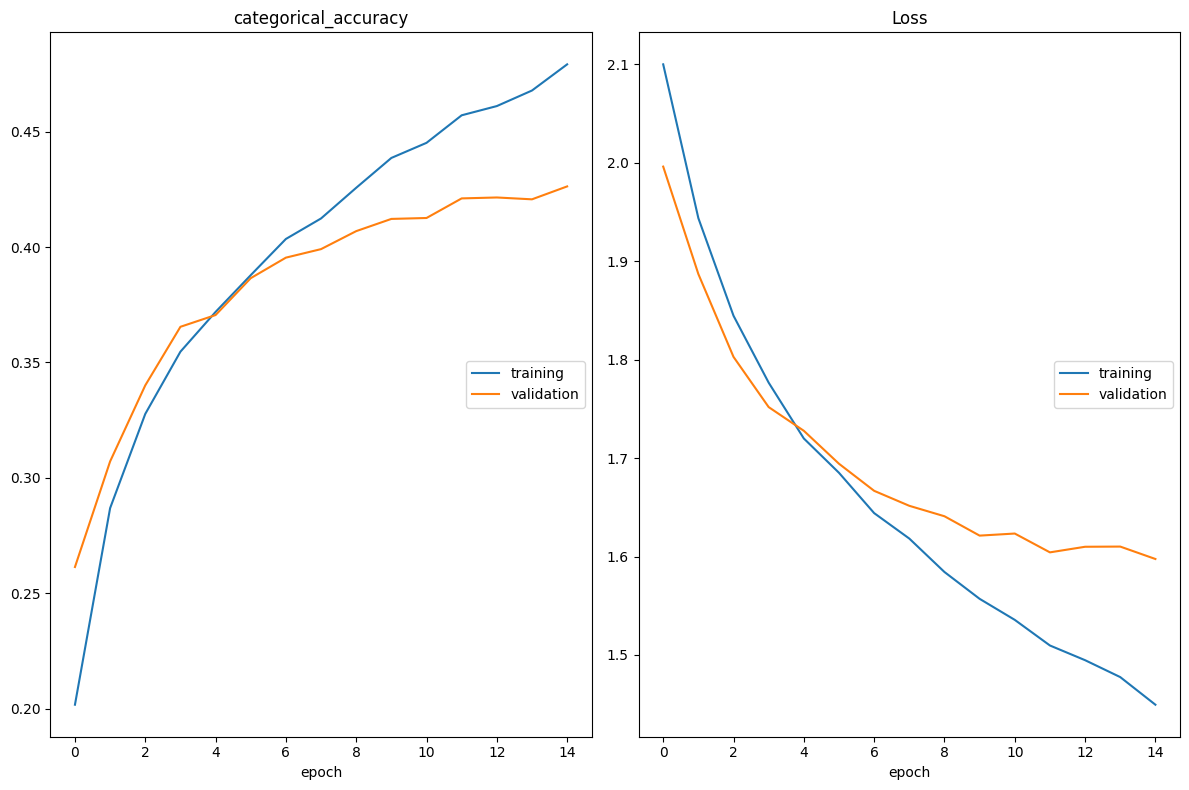

categorical_accuracy
	training         	 (min:    0.202, max:    0.479, cur:    0.479)
	validation       	 (min:    0.261, max:    0.426, cur:    0.426)
Loss
	training         	 (min:    1.449, max:    2.100, cur:    1.449)
	validation       	 (min:    1.598, max:    1.996, cur:    1.598)
626/626 [==============================] - 131s 208ms/step - loss: 1.4495 - categorical_accuracy: 0.4792 - val_loss: 1.5975 - val_categorical_accuracy: 0.4263


In [22]:
history_norm_aug = model_norm_aug.fit(x=train_ds,
                          epochs=EPOCHS,
                          validation_data=valid_ds,
                          callbacks=[PlotLossesKerasTF()])

<b>Categorical accuracy is much better, than on previous models. But model overfits, adding dropout layer.</b>

In [14]:
augmentation_layer = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal"),
                                          tf.keras.layers.RandomRotation(0.1),
                                          tf.keras.layers.RandomContrast(0.1)])
normalization_layer = tf.keras.layers.Rescaling(scale=1./127.5, offset=-1)    

inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = augmentation_layer(inputs)
x = normalization_layer(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.AveragePooling2D()(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.AveragePooling2D()(x)
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.SpatialDropout2D(0.5)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)
model_norm_aug = tf.keras.Model(inputs, outputs)

In [15]:
model_norm_aug.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 conv2d_7 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 average_pooling2d_2 (Averag  (None, 112, 112, 32)     0         
 ePooling2D)                                                     
                                                           

In [16]:
LR = 1e-4
EPOCHS = 15

model_norm_aug.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
                          loss='categorical_crossentropy',
                          metrics=['categorical_accuracy'])

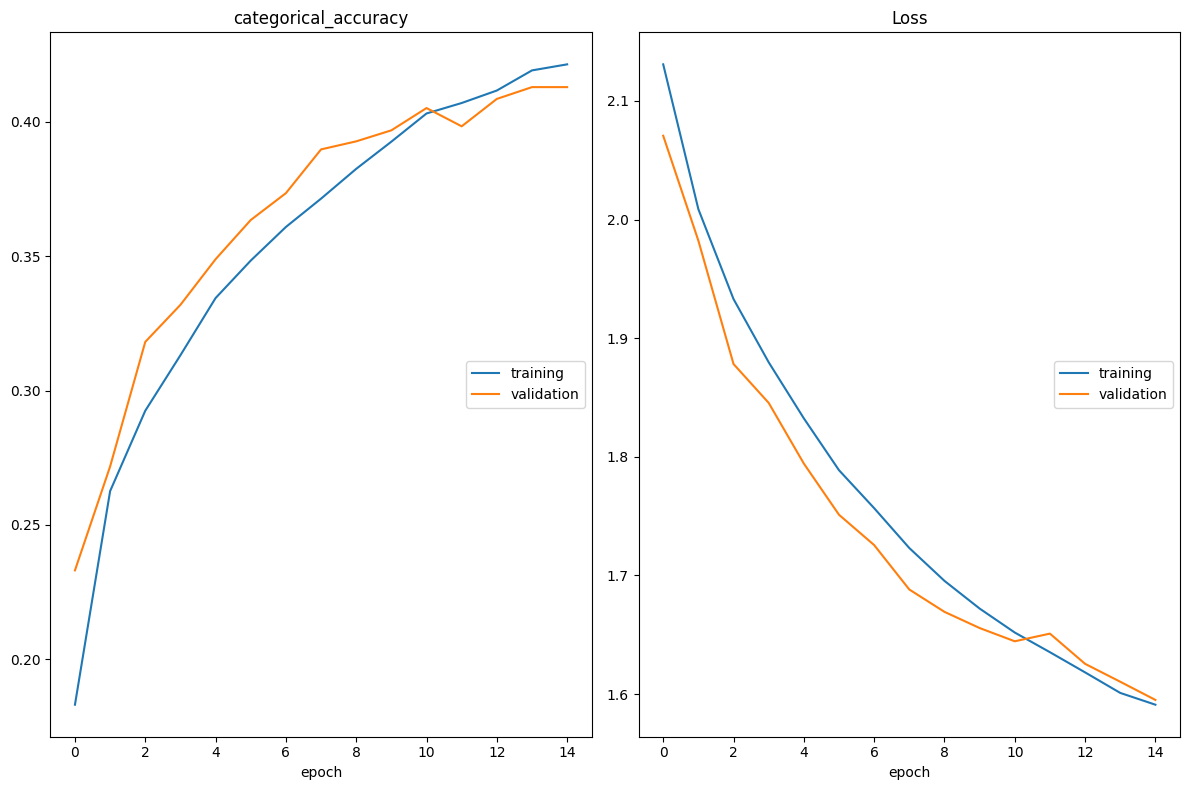

categorical_accuracy
	training         	 (min:    0.183, max:    0.421, cur:    0.421)
	validation       	 (min:    0.233, max:    0.413, cur:    0.413)
Loss
	training         	 (min:    1.591, max:    2.131, cur:    1.591)
	validation       	 (min:    1.595, max:    2.071, cur:    1.595)
626/626 [==============================] - 132s 211ms/step - loss: 1.5910 - categorical_accuracy: 0.4214 - val_loss: 1.5951 - val_categorical_accuracy: 0.4129


In [17]:
history_norm_aug = model_norm_aug.fit(x=train_ds,
                          epochs=EPOCHS,
                          validation_data=valid_ds,
                          callbacks=[PlotLossesKerasTF()])

<b>Categorical accuracy is very good, without overfitting. Saving as best model.</b>

In [18]:
model_norm_aug.save('models/model_08_norm_aug/model_08_norm_aug_15', save_format='h5')